<a href="https://colab.research.google.com/github/bswolley/first/blob/second/usethis_python_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

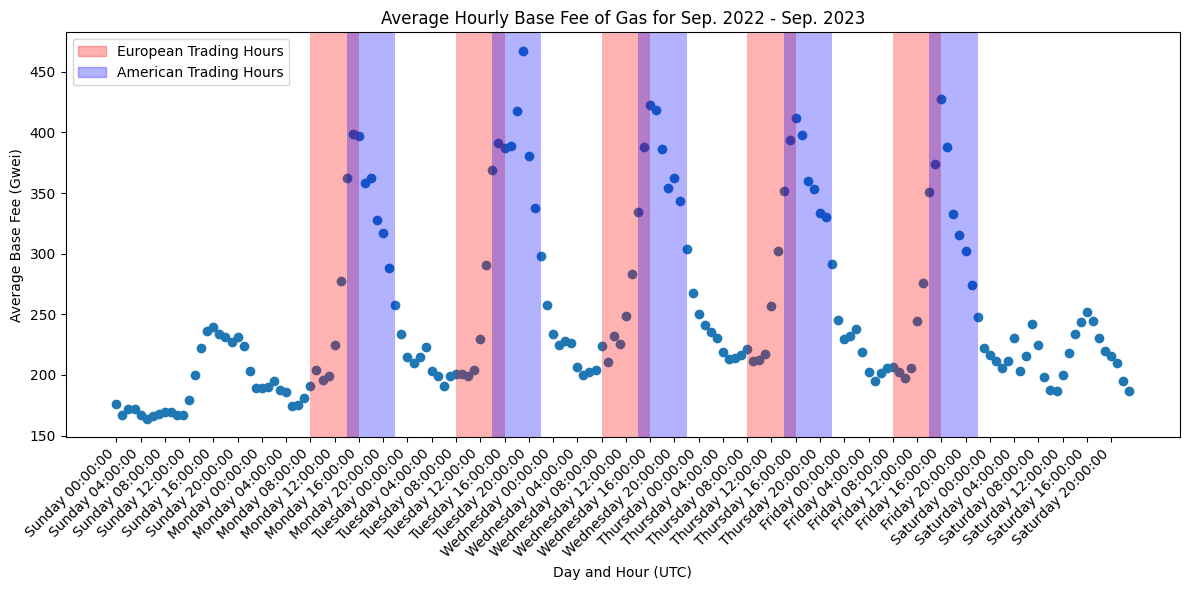

In [9]:
#average gas price for past year by day/hour (issue with daily trading hour rectangles)
import pandas as pd
import matplotlib.pyplot as plt


#read data
data = pd.read_csv("eth_data2.csv")

#convert timestamp to posix
data['hour'] = pd.to_datetime(data['hour'], format='%Y-%m-%d %H:%M:%S') #make sure it has same time format

# new column with weekday/hour formatted to match the x-axis labels
data['weekday_and_hour'] = data['hour'].dt.strftime('%A %H:%M:%S')  # Changed from '%A %H:00:00'
#print(data['hour'])

#group by weekday_and_hour and find average for groupings of the base price of gas
average_data = data.groupby('weekday_and_hour')['avg_base_fee'].mean() / 1e8

#reset the index and rename the column
average_data = average_data.reset_index().rename(columns={'avg_base_fee': 'Average_avg_base_fee'})

#order for weekdays, needed for aggregation
weekday_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

#create x-axis labels
#(each day, every 4 hours ONLY FOR LABELING) - try later with every 4th hour for label, nvm just reduced ticks below
x_labels = []
for day in weekday_order:
    for hour in range(24):  #this will iterate over 24 hours
       x_labels.append(f"{day} {hour:02d}:00:00")


#sort df by custom order
average_data['weekday_and_hour'] = pd.Categorical(average_data['weekday_and_hour'], categories=x_labels, ordered=True)
average_data = average_data.sort_values('weekday_and_hour')

#convert 'weekday_and_hour' back to string before using it in scatter plot
average_data['weekday_and_hour'] = average_data['weekday_and_hour'].astype(str)


#scatterplot
#print(average_data) #its correct going
plt.figure(figsize=(12, 6))
plt.scatter(average_data['weekday_and_hour'], average_data['Average_avg_base_fee'])

#rotate x axis labs 45 degrees
plt.xticks(rotation=45, ha='right')

# Reduce the number of x-axis ticks (e.g., show every 4th tick) - used chatGPT for help with this instead of the above x_label function
#n = 4 - below commented out exaple plotted data correctly but labels were wrong
#plt.xticks(average_data.index[::n], average_data['weekday_and_hour'].iloc[::n], rotation=45, ha='right')
n = 4
plt.xticks(range(0, len(average_data), n), average_data['weekday_and_hour'].iloc[::n], rotation=45, ha='right')

#trading hours
european_trading_hours = ("08:00:00", "16:30:00")
american_trading_hours = ("14:00:00", "21:30:00")

#rectangles
#this worked, add notes to understand
colors = ['red', 'blue']
for i, day in enumerate(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]): #iterates over days with 2 values, i=index of day (0,1,2..) and day=day name
    for j, hour_range in enumerate([(8, 16.5), (14, 21.5)]): #iterates over list w/ tuples, j=index, hour_range=hour range provided
        start, end = hour_range
        color = colors[j] #based on index
        plt.axvspan(f"{day} {start:02.0f}:00:00", f"{day} {end:02.0f}:00:00", facecolor=color, alpha=0.3, ymin=0, ymax=250)
#plt.axvspan used to create vertical rectangles, using day, start, end

#axis labels/title
plt.xlabel('Day and Hour (UTC)')
plt.ylabel('Average Base Fee (Gwei)')
plt.title('Average Hourly Base Fee of Gas for Sep. 2022 - Sep. 2023')

#legends (worked)
legend_labels = ['European Trading Hours', 'American Trading Hours']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color='red', alpha=0.3), plt.Rectangle((0, 0), 1, 1, color='blue', alpha=0.3)]
#above manually creates the legend, .rectangle renders a square at for legend w/ above labels
plt.legend(legend_handles, legend_labels, loc='upper left')




#final plot
plt.tight_layout()
plt.show()


# Plots using two datasets, one for daily average base fee of gas, second being the daily closing price of ETH in USD, for the same time period (2021-2023).

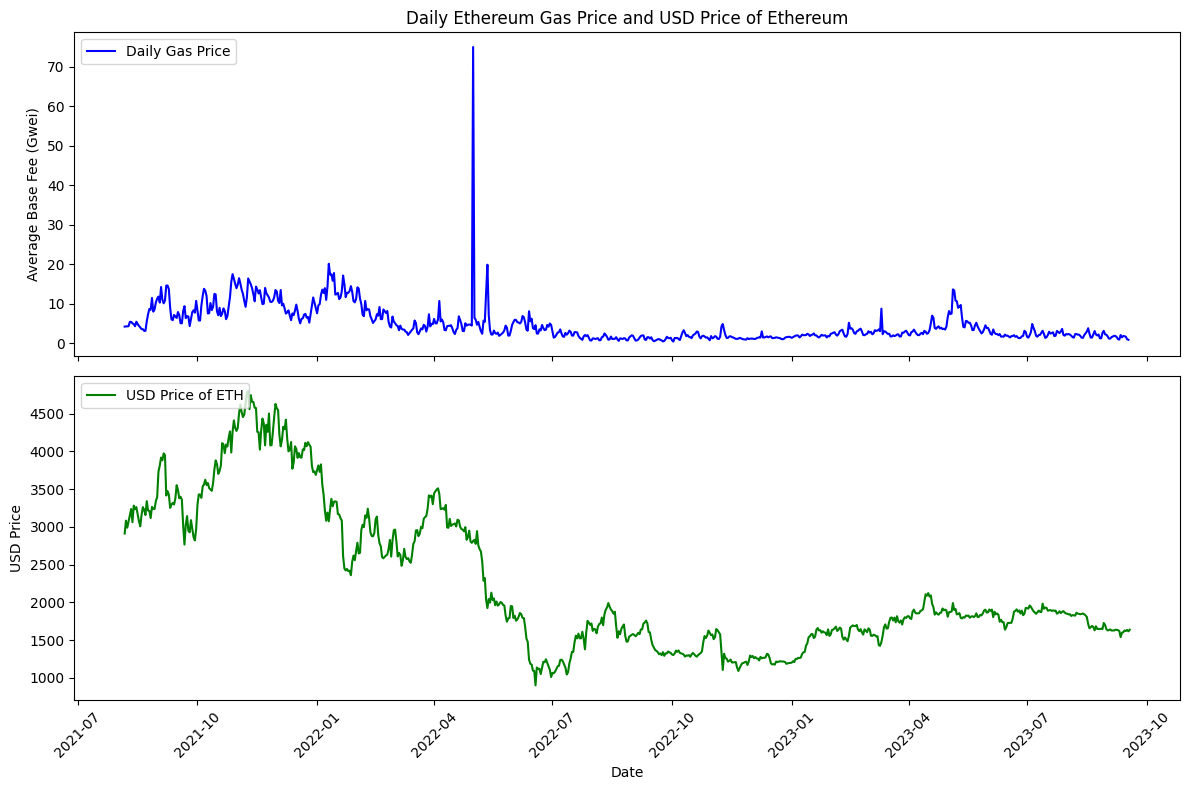

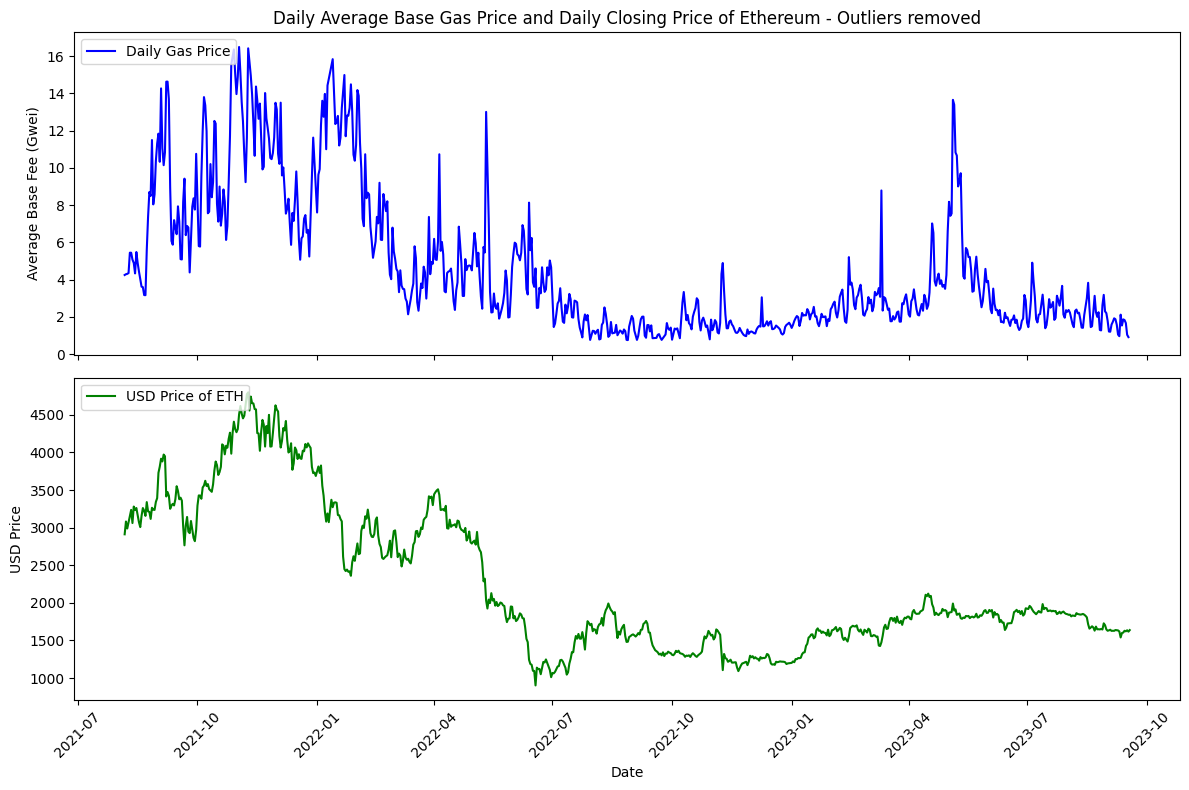

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

#These plots use two data sets, first being daily which has the daily average base price of gas and second being
#usd_eth, which has the daily closing price of ETH in usd, for the same time period as above


#gas price data
daily_data = pd.read_csv("daily.csv")
#print(daily_data)

#usd price of eth data
usd_eth = pd.read_csv("usd_eth_years.csv")
#print(usd_eth)

#day col to yyyy-mm-dd (daily)
daily_data['day'] = pd.to_datetime(daily_data['day'], format='%Y-%m-%d')

#date col to yyyy-mm-dd  (usd_eth)
usd_eth['Date'] = pd.to_datetime(usd_eth['Date'], format='%m/%d/%Y') #changing from '/' in date to '-'

#in R code did some descriptive stats, and found which days had highest/lowest prices (do later?)

#plotting, first create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
#subplot for figure w/ multiple plots, here the 2,1 refer to rows, cols, sharex=True (shared x axis)

#daily eth avg_base_fee
ax1.plot(daily_data['day'], daily_data['avg_base_fee'], label='Daily Gas Price', color='b')
ax1.set_ylabel('Average Base Fee (Gwei)')
ax1.set_title('Daily Ethereum Gas Price and USD Price of Ethereum')

#usd - eth
ax2.plot(usd_eth['Date'], usd_eth['Close'], label='USD Price of ETH', color='g')
ax2.set_ylabel('USD Price')
ax2.set_xlabel('Date')

#legends (not really necessary)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

#rotate x-axis labs
plt.xticks(rotation=45)

#spacing between subplots, this minimizes it
plt.tight_layout()

#display (consider removing outliers?) (UPDATE: done below)
plt.show()

#create same function as in R for outlier removal
def remove_outliers(data, variable, threshold):
    lower_threshold = np.quantile(data[variable], threshold)
    upper_threshold = np.quantile(data[variable], 1 - threshold)
    data_filtered = data[(data[variable] >= lower_threshold) & (data[variable] <= upper_threshold)]
    return data_filtered

#remove outliers from daily data
filtered_daily = remove_outliers(daily_data, 'avg_base_fee', 0.01) #same threshold as in r
#print(filtered_daily)
#print(max(filtered_daily['avg_base_fee'])) 16, probably too low

############# outlier removed plotting below
#plotting, first create figure with 2 subplots
fig_2, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

#daily eth avg_base_fee
ax1.plot(filtered_daily['day'], filtered_daily['avg_base_fee'], label='Daily Gas Price', color='b')
ax1.set_ylabel('Average Base Fee (Gwei)')
ax1.set_title('Daily Average Base Gas Price and Daily Closing Price of Ethereum - Outliers removed')

#usd - eth
ax2.plot(usd_eth['Date'], usd_eth['Close'], label='USD Price of ETH', color='g')
ax2.set_ylabel('USD Price')
ax2.set_xlabel('Date')

#legends (not really necessary)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

#rorate x-axis labs
plt.xticks(rotation=45)

#spacing between subplots
plt.tight_layout()

############# plotly plotting below (Well ok I am not sure why this plot is displayed between the former two, possibly due to fig names?)
# apparently using a mix of plotly and matplot can cause them to render out of order
# plotly figure for daily data
fig1 = px.line(filtered_daily, x='day', y='avg_base_fee', title='Daily Ethereum Gas Price')
fig1.update_xaxes(title_text='Date')
fig1.update_yaxes(title_text='Average Base Fee (Gwei)')

#plotly figure for USD/eth
fig2 = px.line(usd_eth, x='Date', y='Close', title='Daily Closing Price of Ethereum (USD)')
fig2.update_xaxes(title_text='Date')
fig2.update_yaxes(title_text='USD Price')

# Subplot both figures
from plotly.subplots import make_subplots
figX = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Add the traces from fig1 and fig2 to figX
figX.add_trace(fig1.data[0], row=1, col=1)
figX.add_trace(fig2.data[0], row=2, col=1)

# Set subplot titles
figX.update_layout(title_text='Daily Ethereum Gas Price and Daily Closing Price of Ethereum (USD)')

# Display the subplots
figX.show()



# New Section

In [25]:
#This data (trans_data) has avg. daily gas price and was used in R along with seminal dates in eth history as annotations
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

#read data
trans_data = pd.read_csv("trans_data.csv")

#convert gas price
trans_data['avg_gas_price'] = trans_data['avg_gas_price'] / 1e9
#print(trans_data)

#remove outliers
#create same function as in R for outlier removal
def remove_outliers(data, variable, threshold):
    lower_threshold = np.quantile(data[variable], threshold)
    upper_threshold = np.quantile(data[variable], 1 - threshold)
    data_filtered = data[(data[variable] >= lower_threshold) & (data[variable] <= upper_threshold)]
    return data_filtered

#remove outliers from daily data
tdata_filt = remove_outliers(trans_data, 'avg_gas_price', 0.01) #same threshold as in r
#print(tdata_filt)

#important dates
important_dates = [
    "2023-04-12",
    "2023-02-28",
    "2022-09-15",
    "2022-06-29",
    "2021-12-09",
    "2021-10-27",
    "2021-08-06",
    "2021-04-14",
    "2021-02-08",
    "2020-12-01",
    "2020-01-01",
    "2019-02-28"
]

#important corresponding labels
important_labels = [
    "Shapella<br>Shanghai<br>Upgrade",
    "Shapella<br>Hard Fork",
    "The Merge",
    "Network Upgrade<br>(Hard Fork)",
    "Hard Fork",
    "Mainnet Upgrade",
    "London<br>Hard Fork",
    "Berlin<br>Hard Fork",
    "Listing<br>on CME",
    "Ethereum v.2.0",
    "Muir Glacier<br>Hard Fork",
    "St. Petersburg/<br>Constantinople<br>Hard Fork"
]

#create plot with go
fig_10 = go.Figure()

#1st layer scatter of gas prices
fig_10.add_trace(go.Scatter(x=tdata_filt['day'], y=tdata_filt['avg_gas_price'], mode='lines', name='Gas Price'))

#define an offset for labels (adjust as needed)
label_offset = 0.05 #doesnt seem to affect anything
#Plotly figure automatically scales the y-axis based on the data range so it can be changed, but for now gets the job done

#vertical lines and labels for important dates
for date, label in zip(important_dates, important_labels):
  #for lines
    fig_10.add_shape(
        go.layout.Shape(
            type="line",
            x0=date,
            x1=date,
            y0=min(tdata_filt['avg_gas_price']) - label_offset,
            y1=max(tdata_filt['avg_gas_price']) + label_offset,  #adjusted above
            line=dict(color="gray", dash="dash"),
        )
    )
    #for annotations
    fig_10.add_annotation(
        go.layout.Annotation(
            text=label,
            x=date,
            y=max(tdata_filt['avg_gas_price']) + label_offset,  # Adjust the offset
            xshift=10,
            showarrow=False,
        )
    )

#update the layout
fig_10.update_layout(
    title="Gas Price with Important Ethereum Dates",
    xaxis_title="Date",
    yaxis_title="Gas Price (Gwei)",
    xaxis_rangeslider_visible=True, #adds a slider to view different parts, useful for long plots
)

# final plot
fig_10.show()


